First, a Tweet pre-processor:

In [1]:
import re

class TweetPreprocessor(object):

    def __init__(self):
        self.FLAGS = re.MULTILINE | re.DOTALL
        self.ALLCAPS = '<allcaps>'
        self.HASHTAG = '<hashtag>'
        self.URL = '<url>'
        self.USER = '<user>'
        self.SMILE = '<smile>'
        self.LOLFACE = '<lolface>'
        self.SADFACE = '<sadface>'
        self.NEUTRALFACE = '<neutralface>'
        self.HEART = '<heart>'
        self.NUMBER = '<number>'
        self.REPEAT = '<repeat>'
        self.ELONG = '<elong>'

    def _hashtag(self, text):
        text = text.group()
        hashtag_body = text[1:]
        if hashtag_body.isupper():
            result = (self.HASHTAG + " {} " + self.ALLCAPS).format(hashtag_body)
        else:
            result = " ".join([self.HASHTAG] + re.split(r"(?=[A-Z])", hashtag_body, flags=self.FLAGS))
        return result

    def _allcaps(self, text):
        text = text.group()
        return text.lower() + ' ' + self.ALLCAPS

    def preprocess(self, text):
        eyes, nose = r"[8:=;]", r"['`\-]?"

        re_sub = lambda pattern, repl: re.sub(pattern, repl, text, flags=self.FLAGS)

        text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", self.URL)
        text = re_sub(r"/"," / ")
        text = re_sub(r"@\w+", self.USER)
        text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), self.SMILE)
        text = re_sub(r"{}{}p+".format(eyes, nose), self.LOLFACE)
        text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), self.SADFACE)
        text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), self.NEUTRALFACE)
        text = re_sub(r"<3", self.HEART)
        text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", self.NUMBER)
        text = re_sub(r"#\S+", self._hashtag)
        text = re_sub(r"([!?.]){2,}", r"\1 " + self.REPEAT)
        text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 " + self.ELONG)

        text = re_sub(r"([A-Z]){2,}", self._allcaps)

        return text.lower()


Then, let's create the Tweet embeddings:

In [30]:
import numpy

import nltk
from nltk.corpus import stopwords

import json
import pickle

def read(path):
    lines = None
    with open(path, 'r') as f:
        lines = f.readlines()
        f.close()
    return lines


path = 'websummit_20000.json'
str = ' '.join(read(path))
tweets_des = json.loads(str)

unprocessed_tweets = [tweet['text'] for tweet in tweets_des]

# Pre-processing Tweets
tweet_preprocessor = TweetPreprocessor()
tweets = [tweet_preprocessor.preprocess(tweet) for tweet in unprocessed_tweets]

# Retrieving the embedding vectors in each tweet
f = open('glove.twitter.27B.100d.pkl', 'rb')
embeddings = pickle.load(f)['embeddings']

tweet_embeddings = {}
word_embeddings = {}

nltk.download('stopwords')
stop = stopwords.words('english')

stop += ['<hashtag>', 'websummit']

for tweet in tweets:
    tokens = tweet.split()
    mean_vector = None
    norm = 0.0
    for token in tokens:
        if token not in stop:
            if token in embeddings.keys():
                tmp = numpy.asarray(embeddings[token])
                if token not in word_embeddings:
                    word_embeddings[token] = embeddings[token]
                mean_vector = tmp if mean_vector is None else mean_vector + tmp
                norm += 1.0
    if mean_vector is not None:
        mean_vector = mean_vector / norm
        tweet_embeddings[tweet] = mean_vector.tolist()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ipython/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's declare some dimensionality reduction methods, and let's use them for projecting the Tweets into a 2D embedding space

In [33]:
from abc import ABCMeta, abstractmethod

import sklearn
import sklearn.manifold
import sklearn.datasets

class DimensionalityReductionMethod(object):
    __metaclass__ = ABCMeta
    @abstractmethod
    def apply(self, X): pass


class TSNE(DimensionalityReductionMethod):
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.tsne = sklearn.manifold.TSNE(n_components=n_components, early_exaggeration=10)
    def apply(self, X):
        fit = self.tsne.fit(X)
        return fit.embedding_


class MDS(DimensionalityReductionMethod):
    def __init__(self, n_components=2):
        self.mds = sklearn.manifold.MDS(n_components=n_components)
    def apply(self, X):
        fit = self.mds.fit(X)
        return fit.embedding_


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


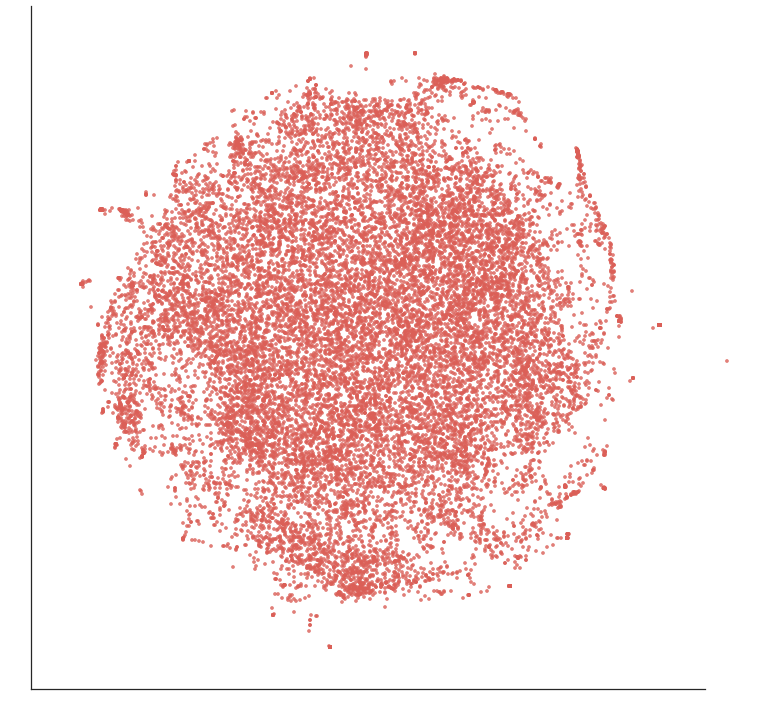

In [34]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas
import seaborn as sns

def show_points(embeddings, manifold_method):
    entities = sorted(embeddings.keys())
    NE = len(entities)
    parameters = [embeddings[entity] for entity in entities]

    marker_size = 10

    X = numpy.asarray(parameters)

    Xr, Zr = X[:, :], None
    Zr = numpy.repeat([0], Xr.shape[0])

    Xr_2d = manifold_method.apply(Xr)

    frame = pandas.DataFrame(dict(x=Xr_2d[:, 0], y=Xr_2d[:, 1], Cluster=Zr))

    fg = sns.lmplot('x', 'y', data=frame, size=10, scatter_kws={'s': marker_size}, hue='Cluster', fit_reg=False)

    for i in range(len(entities)):
        entity = entities[i]
        info = (entity[:30] + '..') if len(entity) > 30 else entity
        #plt.annotate(info, xy = (Xr_2d[i, 0], Xr_2d[i, 1]), size = 'xx-large')

    plt.show(fg)


manifold_method = TSNE()
show_points(tweet_embeddings, manifold_method)
